In [16]:
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
import numpy as np
import metpy.plots as mpplots
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
rs = RadarServer('http://tds-nexrad.scigw.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

In [4]:
query = rs.query()
query.stations('KLVX').time(datetime.utcnow())

time=2021-06-25T01%3A36%3A20.384690&stn=KLVX

In [5]:
rs.validate_query(query)

True

In [6]:
catalog = rs.get_catalog(query)

In [7]:
catalog.datasets

['KLVX20210625_012726_V06']

In [8]:
data = catalog.datasets[0].remote_access()

In [9]:
data

http://tds-nexrad.scigw.unidata.ucar.edu/thredds/cdmremote/nexrad/level2/S3/2021/06/25/KLVX/KLVX20210625_012726_V06
Dimensions:
<class 'siphon.cdmr.dataset.Dimension'> name = scanR_HI, size = 6
<class 'siphon.cdmr.dataset.Dimension'> name = gateR_HI, size = 1832
<class 'siphon.cdmr.dataset.Dimension'> name = radialR_HI, size = 720
<class 'siphon.cdmr.dataset.Dimension'> name = scanR, size = 6
<class 'siphon.cdmr.dataset.Dimension'> name = gateR, size = 1540
<class 'siphon.cdmr.dataset.Dimension'> name = radialR, size = 360
<class 'siphon.cdmr.dataset.Dimension'> name = scanV_HI, size = 3
<class 'siphon.cdmr.dataset.Dimension'> name = gateV_HI, size = 1192
<class 'siphon.cdmr.dataset.Dimension'> name = radialV_HI, size = 720
<class 'siphon.cdmr.dataset.Dimension'> name = scanV, size = 6
<class 'siphon.cdmr.dataset.Dimension'> name = gateV, size = 1192
<class 'siphon.cdmr.dataset.Dimension'> name = radialV, size = 360
<class 'siphon.cdmr.dataset.Dimension'> name = scanD_HI, size = 3
<cla

In [10]:
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

In [11]:
sweep = 0
ref_var = data.variables['Reflectivity_HI']
ref_data = ref_var[sweep]
rng = data.variables['distanceR_HI'][:]
az = data.variables['azimuthR_HI'][sweep]

In [12]:
ref = raw_to_masked_float(ref_var, ref_data)
x, y = polar_to_cartesian(az, rng)

In [13]:
ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

In [14]:
def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = ccrs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_axes([0.02, 0.02, 0.96, 0.96], projection=proj)

    # Add coastlines and states
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    
    return ax

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


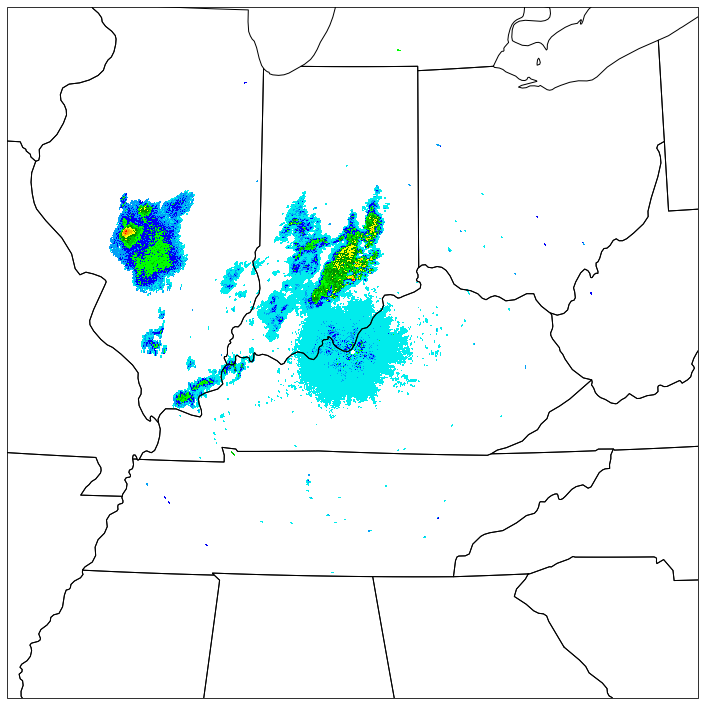

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)
ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

In [ ]:
query = rs.query()
dt = datetime(2012, 10, 29, 15) # Our specified time
query.lonlat_point(-73.687, 41.175).time_range(dt, dt + timedelta(hours=1))

In [ ]:
cat = rs.get_catalog(query)
cat.datasets

In [ ]:
ds = cat.datasets[0]
data = ds.remote_access()
fig = plt.figure(figsize=(10, 7.5))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)

# Set limits in lat/lon space
ax.set_extent([-77, -70, 37, 41])

ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))

In [ ]:
meshes = []
for ds_name in cat.datasets:
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    data = cat.datasets[ds_name].remote_access()

    # Pull out the data of interest
    sweep = 0
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref_var = data.variables['Reflectivity_HI']

    # Convert data to float and coordinates to Cartesian
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.7, 0.02, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    
    # Collect the things we've plotted so we can animate
    meshes.append((mesh, text))

In [ ]:
# Set up matplotlib to do the conversion to HTML5 video
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

# Create an animation
from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)